In [1]:
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.ticker import NullFormatter
import glob
import time
import math
import numba
import sys

import random


nframes=50000
screen_size=(100,100) #Only tested with 100x100 so far


copy_noise_max=10
non_copy_noise_max=10

noise_under_image_max=5

In [2]:
#This function draws a speckle on a chosen frame of the dataset

#NOTE: Size only takes odd arguments
@numba.njit()

def addSpeckle(x,y,size,dataset,intensity_peak,frame):
    x_size=dataset.shape[1]
    y_size=dataset.shape[2]
    
    if size%2==1:
        speckle_x1=x-(size-1)//2
        speckle_x2=x+(size-1)//2
        
        speckle_y1=y-(size-1)//2
        speckle_y2=y+(size-1)//2
        
    else:
        return
    num_stages=(size+1)/2
    
    stage_intensity=intensity_peak/num_stages
    while (speckle_x2-speckle_x1!=0):
        
        dataset[frame,speckle_x1:speckle_x2+1,speckle_y1:speckle_y2+1] += stage_intensity
        
        speckle_x1+=1
        speckle_x2-=1
        speckle_y1+=1
        speckle_y2-=1
        
    dataset[frame,x,y]+=stage_intensity
    
        
    
        
        

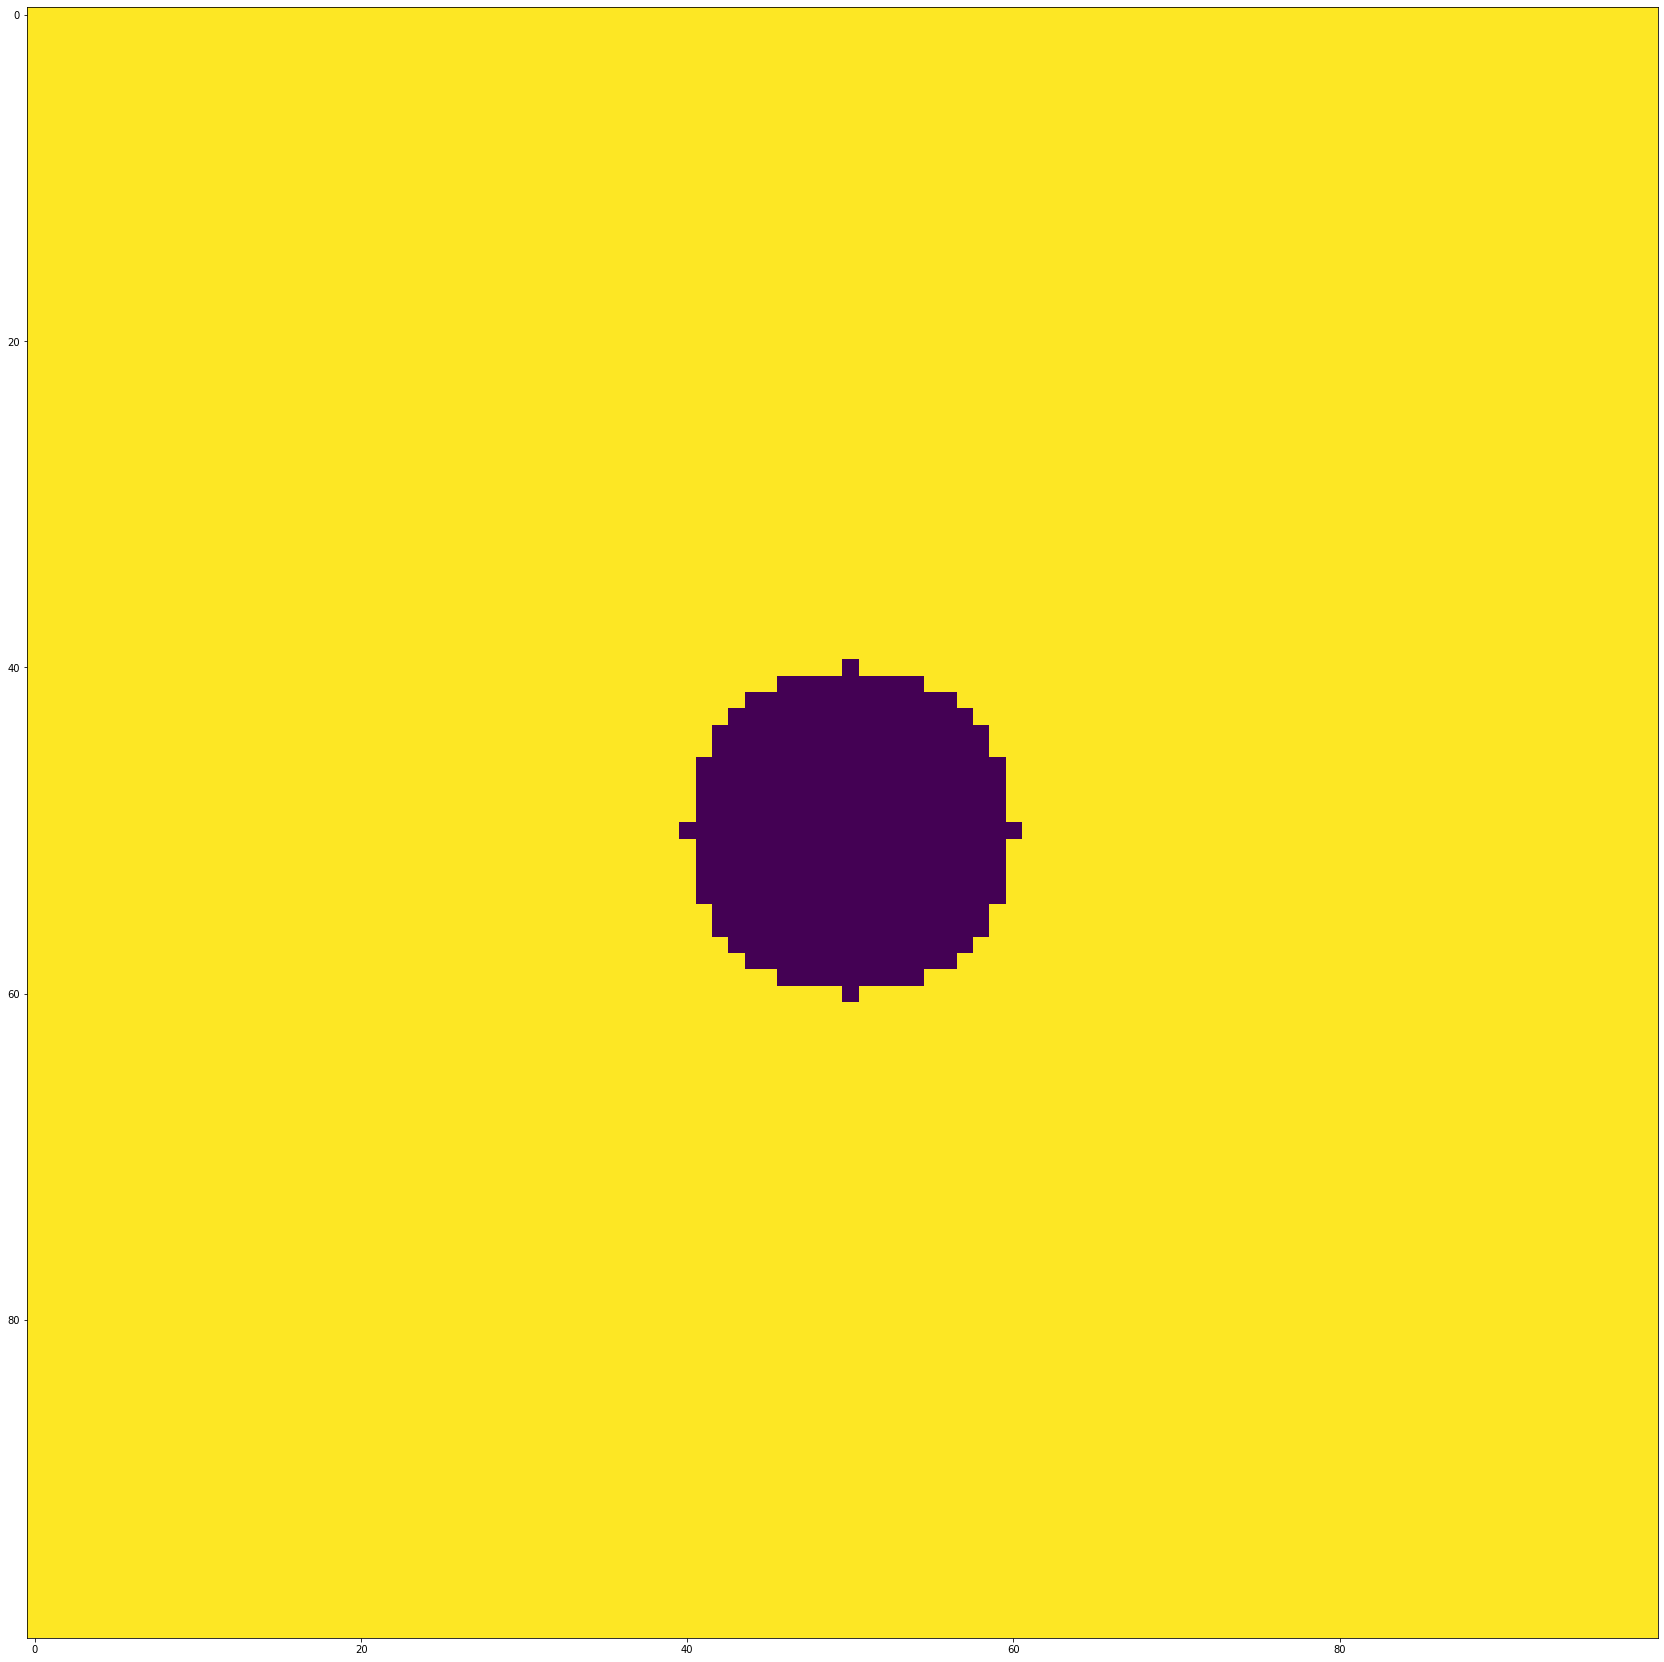

In [3]:
#Choose mask shape in this cell



def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask





#Define Mask Shape

mask=np.ndarray(shape=screen_size) #Has to be same size as speckle dataset. 1 for no object, 0 for object
mask.fill(1)


#Square
#mask[40:60,40:60]=0



#'Wire'
#mask[49:53,0:100]=0


mask=create_circular_mask(screen_size[0],screen_size[1],radius=10)
mask=np.invert(mask)


fig, ax = plt.subplots(ncols=1,nrows=1, figsize=(30, 30))
_=ax.imshow(mask[:,:])




In [4]:
#This Function creates speckles and speckles_with_mask

@numba.njit(parallel=True)
def make_speckles():
    
    anti_mask=np.invert(mask)
    speckles=np.zeros(shape=(nframes,screen_size[0],screen_size[1]))
        
    for i in numba.prange(nframes):
    #for i in numba.prange(screen_size[0]):

        #This adds copied noise (identical noise on both datasets)

        for j in numba.prange(speckles.shape[1]):
            for k in numba.prange(speckles.shape[2]):
                speckles[i,j,k]+=random.randrange(0,copy_noise_max)
        
        

        #This adds speckles
        for k in numba.prange(300):
            addSpeckle(random.randrange(10,90),random.randrange(10,90),random.randrange(0,8)*2+1,speckles,random.randrange(0,100),i)
        
    print("Speckles created. Cutting out the mask..")


    #speckles_with_mask=np.copy(speckles)

    speckles_with_mask=np.zeros(shape=speckles.shape)
    #speckles_with_mask=np.ndarray(shape=speckles.shape)
    
    
    #Cut out the mask
    
   

    for i in numba.prange(speckles_with_mask.shape[0]):
        for j in numba.prange (speckles_with_mask.shape[1]):
            for k in numba.prange(speckles_with_mask.shape[2]):
                speckles_with_mask[i,j,k]=speckles[i,j,k] * mask [j,k]       +    random.randrange(int(non_copy_noise_max*(-1)),non_copy_noise_max) * mask [j,k] + random.randrange(0,noise_under_image_max) * anti_mask[j,k]
               #                 (cutting out the mask   ^ )   (add random non-copied noise outside of the mask ^ )      (add non-copied noise INSIDE the mask ^)     
                
                
                
                

    return (speckles,speckles_with_mask)









In [5]:
(speckles,speckles_with_mask)=make_speckles()

Speckles created. Cutting out the mask..


In [6]:
#This function does the ghose imaging


@numba.njit(parallel=True)
def ghostPixel():
    
    ghost=np.zeros(shape=screen_size,dtype=np.double)
    

    
    
    
    #buckets = frames[:,s1x1:s1x2,s1y1:s1y2].sum(axis=(1,2))
    
    
    buckets=[]
    
    for i in range(nframes):
        buckets.append(np.sum(speckles_with_mask[i,:,:]))
    
    
    for i in numba.prange(100):
        for j in numba.prange(100):
            term1=0
            term2=0
            term3=0
            #This loop goes over 10000 frames
            for frame_ct in numba.prange(nframes):

                #This is I_i
                beam1_bucket=np.double(buckets[frame_ct])

                #This is S_i
                beam2_pixel=np.double(speckles[frame_ct,i,j])
                #Where i is the index of a frame (frame_ct in code)
                #Note that this 'i' is not the same as  the 'i' in the first for-loop above. This 'i' is the x coordinate of the image



                term1+=beam1_bucket*beam2_pixel
                term2+=beam1_bucket
                term3+=beam2_pixel




            #After the three summations have been assembled, put them into formula (3) to produce the ghost image at the [i,j] coordinate 
            ghost[i,j]=term1/nframes-(term2*term3)/ (nframes ** 2)
    return ghost






In [7]:
test=ghostPixel()

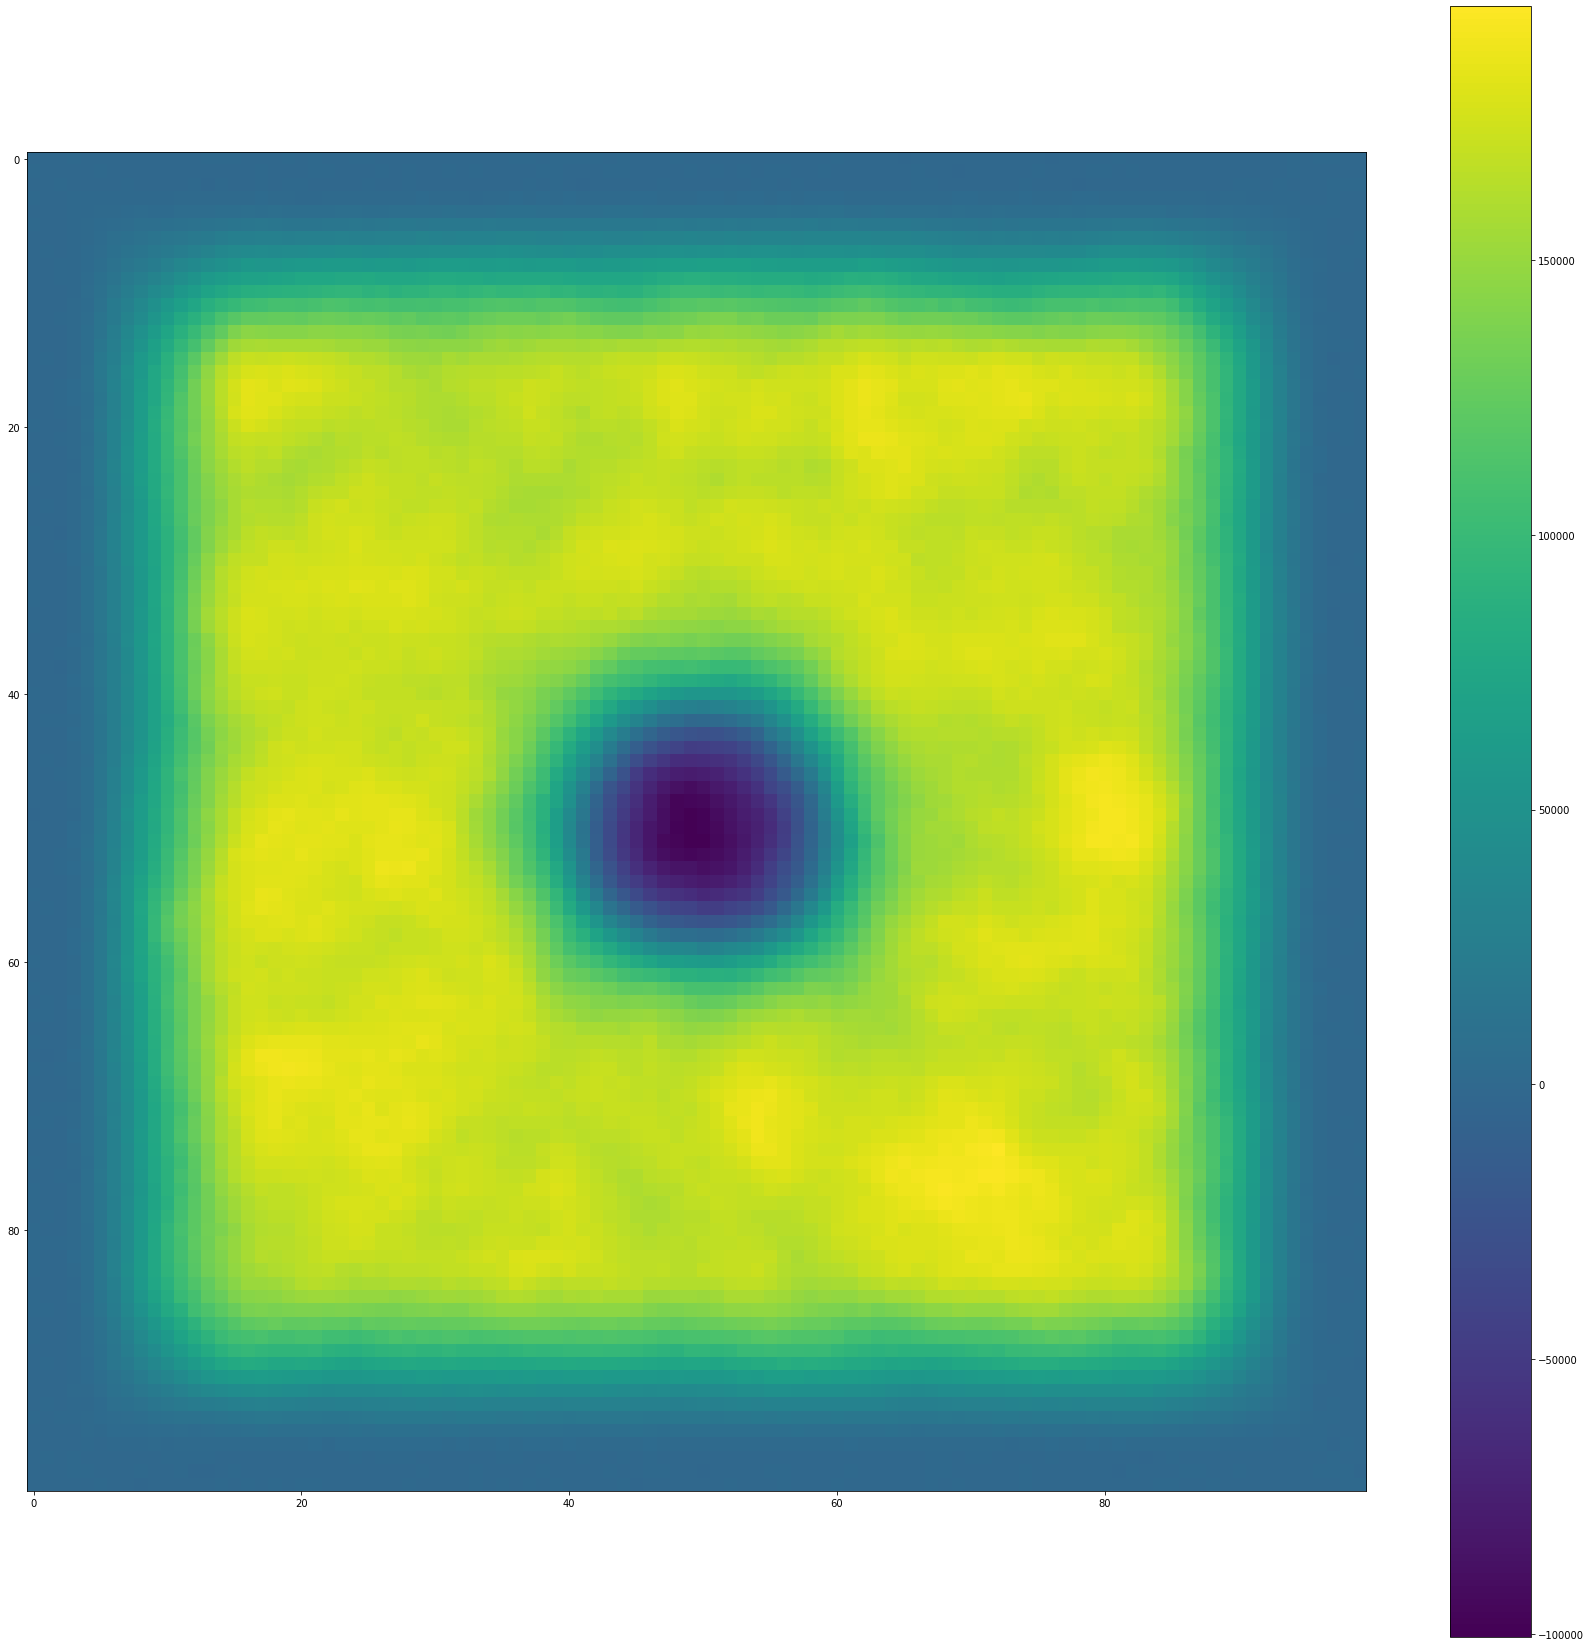

In [8]:
#Show the ghost
fig, ax = plt.subplots(ncols=1,nrows=1, figsize=(30, 30))
_=ax.imshow(test)
fig.colorbar(_)


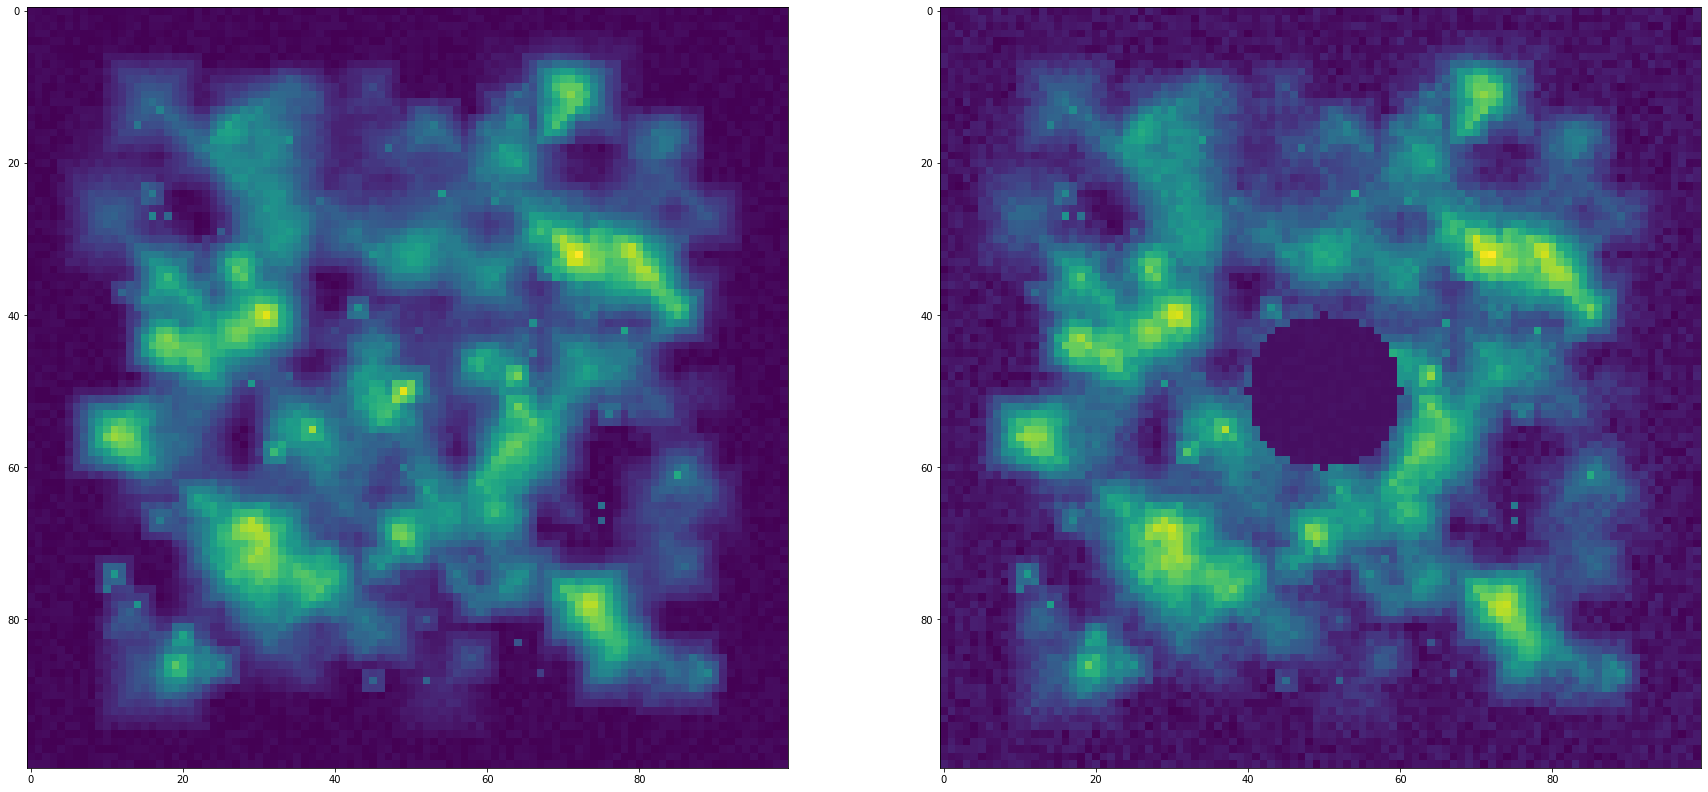

In [11]:
fig, ax = plt.subplots(ncols=2,nrows=1, figsize=(30, 30))
frame_index=random.randrange(nframes)


_=ax[0].imshow(speckles[frame_index,:,:])
_=ax[1].imshow(speckles_with_mask[frame_index,:,:])